# Water temperature analysis

#### Mark Gibbs, Gibbs Consulting

This notebook analyses a time series of water temperatures taken from the BC Provincial Government website [AQUARIUS](http://aqrt.nrs.gov.bc.ca/) portal. The data in question are a sample of water temperature readings from a location on the Koksilah River in the Cowichan Valley on Vancouver Island.


## Ingestion

First, import the needed python libraries and then read in the water temperature data from a csv file. This file is a locally cached copy of a three-year dataset.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
raw_temps = pd.read_csv("raw_data/water_temps_kok002.csv",header=2)
dt = pd.to_datetime(raw_temps['Timestamp (UTC-08:00)'])
temps = pd.DataFrame({'Timestamp':dt,'Temperature':raw_temps['Value (Celsius)']})

## Process

The data is hourly, with the odd gap. Convert to a monthly average

In [3]:
temps['year'] = temps['Timestamp'].apply(lambda x: x.year)
temps['month'] = temps['Timestamp'].apply(lambda x: x.month)

In [4]:
def build_averages(*groupCols):
    mean_temp = temps.groupby(groupCols).mean()['Temperature']
    var_temp = temps.groupby(groupCols).var()['Temperature']
    return pd.DataFrame({'Mean':mean_temp,'Variance':var_temp}).reset_index()

In [5]:
per_month = build_averages('year','month')
per_month['start_date'] = per_month.apply(lambda x: datetime(year=int(x['year']),month=int(x['month']),day=1),axis=1)
per_month.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
year          36 non-null int64
month         36 non-null int64
Mean          36 non-null float64
Variance      36 non-null float64
start_date    36 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 1.5 KB


## Present

We can now show off the results. First, just a simple plot of the monthly average, and then a second one with the variance of the readings also shown.

Text(0.5,0.98,'Monthly Average Temperature, Celsius)')

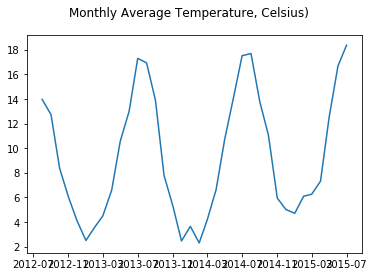

In [6]:
plt.plot(per_month['start_date'],per_month['Mean'])
plt.suptitle("Monthly Average Temperature, Celsius)",fontsize=12)

Text(0.5,0.98,'Average temperature with variance, Celsius)')

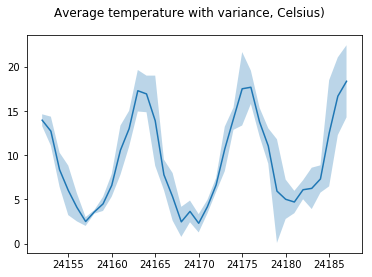

In [7]:
per_month['sd_num'] = per_month.apply(lambda x: x['year']*12 + x['month'],axis=1)
plt.plot(per_month['sd_num'],per_month['Mean'])
per_month['up'] = per_month['Mean'] + per_month['Variance']
per_month['dn'] = per_month['Mean'] - per_month['Variance']
plt.fill_between(per_month['sd_num'], per_month['up'], per_month['dn'], alpha=0.3)
plt.suptitle("Average temperature with variance, Celsius)",fontsize=12)

## Fourier Filtering

The monthly data, despite the averaging, is quite raw. Filtering out some of the noise is possible by using a fourier transformation and then removing the higher-frequency components.

In [8]:
from scipy import fftpack
def fourier_trimming(raw_data, split=9):
    omega = fftpack.fft(raw_data)
    reproc_raw = fftpack.fft(omega)
    # Filter out high frequency component
    mid = int(len(omega)/2)
    for i in range(mid-split,mid+split):
        omega[i] = 0
    reproc_filtered = fftpack.fft(omega)
    # Reverse data if needed
    ln = len(raw_data) - 1
    initial = raw_data[0] > raw_data[ln]
    final = reproc_raw[0] > reproc_raw[ln]
    if initial != final:
        reproc_filtered = np.flip(reproc_filtered,axis=0)
        reproc_raw = np.flip(reproc_raw,axis=0)
    
    return (reproc_filtered, reproc_raw)

Text(0.5,0.98,'Raw and filtered average temperature, Celsius)')

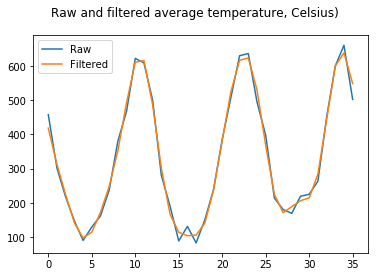

In [9]:
filt, raw = fourier_trimming(per_month['Mean'])
plt.plot(np.abs(raw),label="Raw")
plt.plot(np.abs(filt),label="Filtered")
plt.legend()
plt.suptitle("Raw and filtered average temperature, Celsius)",fontsize=12)

## Daily effects

Returning to the raw data - is it possible to see short-term temperature effects such as daily or from the lunar month? Both annual and daily are to be expected, but not necessarily a monthly one.

Text(0.5,0.98,'Hourly temperature readings, Celsius')

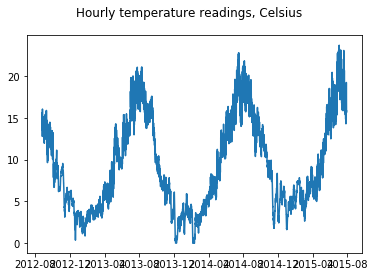

In [10]:
plt.plot(temps["Timestamp"],temps["Temperature"])
plt.suptitle("Hourly temperature readings, Celsius",fontsize=12)

One way to identify periodicity in a time series is to examine the Fourier transform of the data. A series of real values has in general a complex-valued transform, due to the encoding of phase information in the frequency spectrum.

Note that the library used here follows the general practice of having the highest frequency components in the middle of the transformed values.

In [11]:
daily_omega = fftpack.fft(temps["Temperature"].dropna())
daily_omega

array([ 235191.11600000    +0.j        ,     506.12635208 +9366.28162823j,
         -9926.03253068 +3220.69299298j, ...,
         83825.41728749-27343.73475988j,   -9926.03253068 -3220.69299298j,
           506.12635208 -9366.28162823j])

The density of the frequency spectrum reveals the periodic behaviour. The very low frequency components for the average level and annual variation dominate, so a logarithmic plot is appropriate.

Text(0.5,0.98,'Frequency spectrum of temperature data')

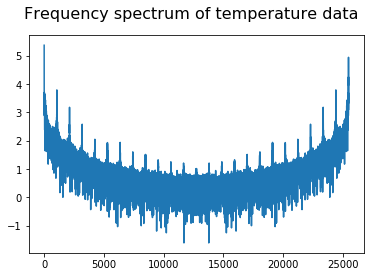

In [12]:
plt.plot(np.log10(np.abs(daily_omega)))
plt.suptitle("Frequency spectrum of temperature data", fontsize=16)

The comb structure represents periodicity in the time series. The overall dataset covers three years of hourly observations, from which the frequency of different timescales can be derived.

In [13]:
yearFreq = 3
monthFreq = yearFreq * 12
dayFreq = yearFreq * 365
lunarFreq = int(dayFreq / 29)
hourFreq = dayFreq * 24

print(monthFreq,dayFreq,lunarFreq,hourFreq)

36 1095 37 26280


A daily component to the time series will manifest as a peak in the spectrum around 1095. This is quite evident from inspecting a subset of the data. As before, a logarithmic scale is used.

(0, 1500)

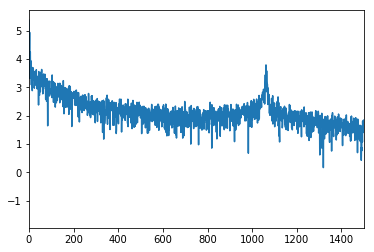

In [14]:
plt.plot(np.log10(np.abs(daily_omega)))
plt.gca().set_xlim([0,1500])

A lunar component, on the other hand, would appear at about 37. However, in this case a visual inspection reveals nothing. Note that this time, a linear rather than logarithmic scale has been used.

(20, 60)

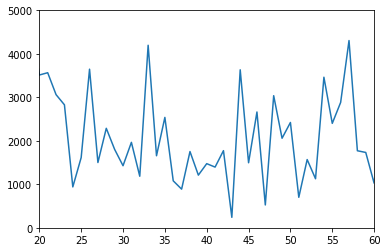

In [15]:
plt.plot(np.abs(daily_omega))
plt.gca().set_ylim([0,5000])
plt.gca().set_xlim([20,60])
